In [3]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["TORCH_USE_CUDA_DSA"] = '1'

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split

import os
import argparse

import torchvision.transforms as T
from torchvision.datasets import CIFAR100
from torch.utils.data import DataLoader

from einops import rearrange, repeat
from einops.layers.torch import Reduce
from torchsummary import summary

#from vit import ViT
from tqdm import tqdm

In [8]:
# parser = argparse.ArgumentParser(description="ViT")


# parser.add_argument('--epoch', default=32, type=int)
# parser.add_argument('--batch_size', default=100, type=int)
# parser.add_argument('--lr', default=1e-3, type=float)
# parser.add_argument('--in_channels', default=3, type=int)
# parser.add_argument('--img_size', default=32, type=int)
# parser.add_argument('--patch_size', default=8, type=int)
# parser.add_argument('--embedding_dim', default=192, type=int)
# parser.add_argument('--encoder_depth', default=12, type=int)
# parser.add_argument('--num_heads', default=8, type=int)
# parser.add_argument('--mlp_dim', default=768, type=int)
# parser.add_argument('--drop_rate', default=0.1, type=float)
# parser.add_argument('--num_classes', default=100, type=int)

# args = parser.parse_args()

epochs=32
batch_size=100
lr=1e-3

in_channels=3
img_size=32
patch_size=8
embedding_dim=192
encoder_depth=12
num_heads = 8
mlp_dim = 768
drop_rate = 0.1
num_classes=100

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [10]:
os.getcwd()

'/Users/jamespark/workspace/ViT'

In [11]:
# download dataset
os.makedirs('/Users/jamespark/workspace/ViT', exist_ok=True)

train_set = CIFAR100(root='/Users/jamespark/workspace/ViT',
                    train=True,
                    download=True,
                    transform=T.Compose([
                        T.RandomHorizontalFlip(),
                        T.ToTensor(),
                        T.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))
                    ])
)
test_set = CIFAR100(root='/Users/jamespark/workspace/ViT',
                    train=False,
                    download=True,
                    transform=T.Compose([
                        T.ToTensor(),
                        T.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))
                    ])
)

# dataloader
train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True, num_workers=5)
test_loader = DataLoader(dataset=test_set, batch_size=batch_size, shuffle=False, num_workers=5)

100.0%


Extracting /Users/jamespark/workspace/ViT/cifar-100-python.tar.gz to /Users/jamespark/workspace/ViT
Files already downloaded and verified


In [12]:
print(train_set.data.shape)
print(len(train_set.targets))
print(test_set.data.shape)
print(len(test_set.targets))

(50000, 32, 32, 3)
50000
(10000, 32, 32, 3)
10000


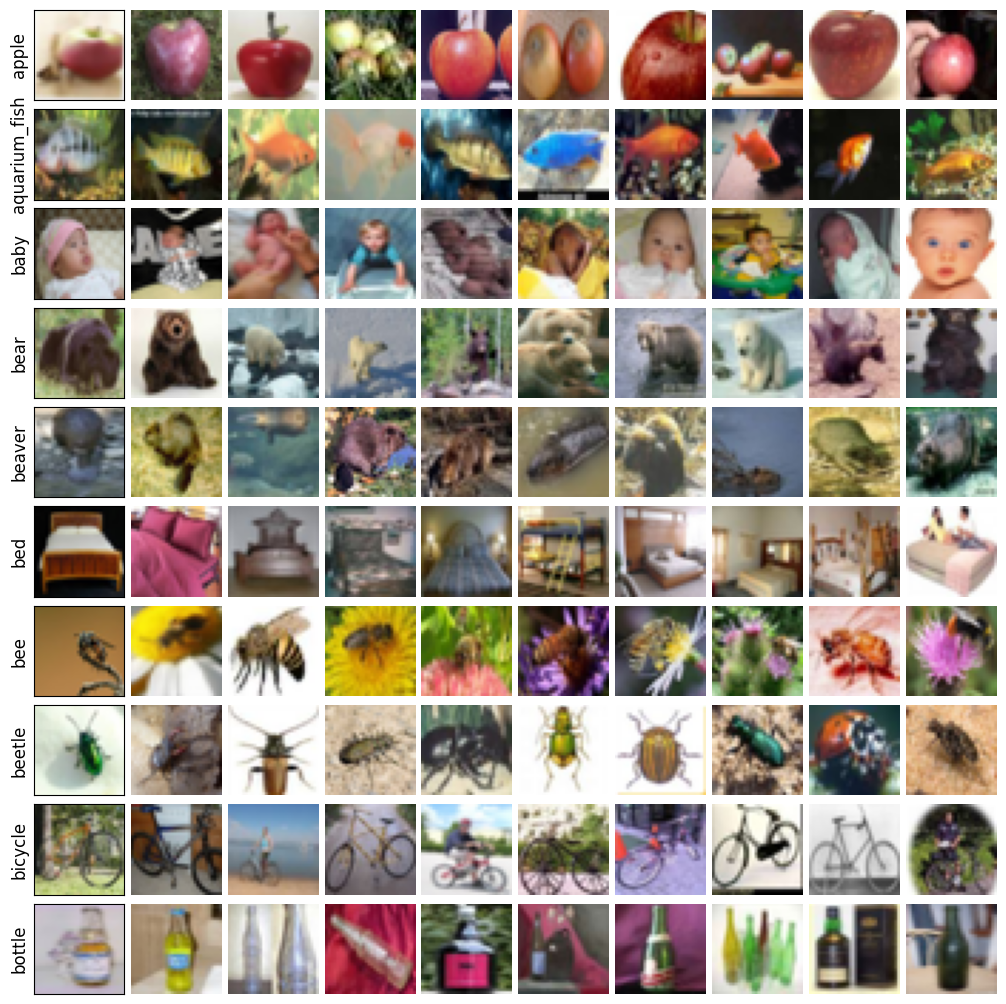

In [14]:
import matplotlib.pyplot as plt
import numpy as np

row_num, col_num = 10, 10
fig, ax = plt.subplots(row_num, col_num, figsize=(10, 10))

for label_class, plot_row in enumerate(ax):
    ## array of index per each target classes
    label_idx = np.where(np.array(train_set.targets) == label_class)[0]
    for i, plot_cell in enumerate(plot_row):
        if i == 0:
            ## adding class label at ylabel axis
            plot_cell.set_ylabel(train_set.classes[label_class], fontsize=12)
            ## no ticks at x, y axis
            plot_cell.set_yticks([])
            plot_cell.set_xticks([])
            idx = label_idx[i]
            img = train_set.data[idx]
            plot_cell.imshow(img)
        else:
            # turn off axis
            plot_cell.axis('off')
            # pick the first 10 images from each classes
            idx = label_idx[i]
            img = train_set.data[idx]
            plot_cell.imshow(img)
            
# Adjust the padding between and around subplots     
plt.tight_layout(pad=0.5)

In [7]:
# class PositionalEncoding(nn.Module):
#     def __init__(self):
#         super(PositionalEncoding, self).__init__()

#     def forward(self, x):
#         ##### 덧셈이 addition인지 뒤에 concat되는건지 #####
#         return x + self.encoding

class PatchEmbedding(nn.Module):
    def __init__(self, batch_size: int=100, in_channels: int=3, img_size: int=32, patch_size: int=8, embedding_dim: int=192, pre_train: bool=False):
        super(PatchEmbedding, self).__init__()
        self.batch_size = batch_size          # =B
        self.in_channels = in_channels        # =C
        self.image_size = img_size            # =H =W
        self.patch_size = patch_size          # =P
        self.embedding_dim = embedding_dim    # =D
        self.pre_train = pre_train

        self.linear = nn.Linear(patch_size * patch_size * in_channels, embedding_dim)
        self.class_token = nn.Parameter(torch.randn(1, 1, embedding_dim))
        # self.positional_encoding = PositionalEncoding()
        self.positional_encoding = nn.Parameter(torch.randn((img_size // patch_size) **2 + 1, embedding_dim))

        self.mask_token = nn.Parameter(torch.zeros(1, 1, embedding_dim)) if pre_train else None

    def forward(self, x, bool_masked_pos: Optional[torch.BoolTensor] = None):
        # print(x.shape, self.batch_size)
        assert x.shape[0] == self.batch_size

        b, c, h, w = x.shape

        # 1. slice into patches
        # input : [b, c, h, w]
        # patches : [b, N=HW/p^2, P^2C]
        x = rearrange(x, 'b c (h1 h2) (w1 w2) -> b (h2 w2) (h1 w1 c)', h1=self.patch_size, w1=self.patch_size)

        # linear projection
        # [b, N, P^2C] -> [b, N, D]
        x = self.linear(x)

        ##########################################################################################
        # masking for pretrain
        # shape remains the same
        if self.pre_train:
            # masking for pre-training
            mask_tokens = mask_token.expand(batch_size, (img_size // patch_size) **2, -1)
            mask = bool_masked_pos.unsqueeze(-1).type_as(mask_tokens)
            x = x * (1.0 - mask) + mask_tokens * mask
        ##########################################################################################


        # 2. prepend class token
        class_tokens = repeat(self.class_token,'() n d -> b n d', b=self.batch_size) 
        ####### broadcasting안되나 굳이 repeat 써야하나 #######
        x = torch.cat([class_tokens, x], dim=1)
        # print(class_tokens.shape)
        
        # 3. add positional encoding
        # x = self.positional_encoding(x)
        x += self.positional_encoding

        # [10, 3, 32, 32] -> [10, 16, 192] -> [10, 17, 192]
        return x


class MultiHeadAttention(nn.Module):
    def __init__(self, embedding_dim: int=192, num_heads: int=8):
        super(MultiHeadAttention, self).__init__()
        self.embedding_dim = embedding_dim
        self.num_heads = num_heads
        self.qkv = nn.Linear(embedding_dim, embedding_dim*3, bias=False)  # 편의를 위해 qkv를 한꺼번에 계산하며, multihead처리를 위해 rearrange해줌
        self.projection = nn.Linear(embedding_dim, embedding_dim)

    def forward(self, x):
        # x : [b, N+1, embedding_dim]

        x = self.qkv(x) # [b, N+1, embedding_dim] -> [b, N+1, embedding_dim*3]
        q, k, v = rearrange(x, "b n (qkv h d) -> qkv b h n d", qkv=3, h=self.num_heads) # [3, b, num_heads, N+1, embedding_dim/num_heads]
        # q, k, v 각각 [b, num_heads, N+1, embedding_dim/num_heads]

        # attention(q,k,v) = sofrmax(QK^T/sqrt{d_k})V
        attention_dist = F.softmax(torch.einsum('bhqd, bhkd -> bhqk', q, k) / (self.embedding_dim**0.5), dim=-1)
        out = torch.einsum('bhal, bhlv -> bhav', attention_dist, v)
        out = rearrange(out, "b h n d -> b n (h d)")  # multi-head를 하나로 합쳐주기

        out = self.projection(out)
        # 마지막에 layer 하나더 왜 통과지?

        # Dropout?

        return out


class MLPLayer(nn.Module):
    def __init__(self, dim, mlp_dim, drop_rate):
        super(MLPLayer, self).__init__()
        self.fc1 = nn.Linear(dim, mlp_dim)
        self.dropout = nn.Dropout(drop_rate)
        self.fc2 = nn.Linear(mlp_dim, dim)

    def forward(self, x):
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.dropout(x)
        x = self.fc2(x)

        return x


class ResidualBlock(nn.Module):
    def __init__(self, function):
        super(ResidualBlock, self).__init__()
        self.function = function

    def forward(self, x):
        residual = x
        return self.function(x) + residual


class TransformerEncoderBlock(nn.Module):
    def __init__(self, embedding_dim: int=192, num_heads: int=8, mlp_dim: int=768, drop_rate: float=0.1, **kwargs):
        super(TransformerEncoderBlock, self).__init__()
        self.embedding_dim = embedding_dim
        self.num_heads = num_heads
        self.mlp_dim = mlp_dim
        self.drop_rate = drop_rate
        
        self.attention_block_res = ResidualBlock(
            nn.Sequential(
                nn.LayerNorm(embedding_dim),
                MultiHeadAttention(embedding_dim=embedding_dim, num_heads=num_heads, **kwargs)
            )
        )
        self.MLP_block_res = ResidualBlock(
            nn.Sequential(
                nn.LayerNorm(embedding_dim),
                MLPLayer(dim=embedding_dim, mlp_dim=mlp_dim, drop_rate=drop_rate),
            )
        )

    def forward(self, x):
        x = self.attention_block_res(x)
        x = self.MLP_block_res(x)

        return x


class TransformerEncoder(nn.Sequential):
    def __init__(self, encoder_depth: int=12, **kwargs):
        super(TransformerEncoder, self).__init__(
            *[
                TransformerEncoderBlock(**kwargs) for _ in range(encoder_depth)
            ]
        )


class ClassificationHead(nn.Module):
    # pre-training : MLP w/ one hidden layer
    # fine-tuning : single linear layer
    def __init__(self, embedding_dim: int=192, num_classes: int=100):
        super(ClassificationHead, self).__init__()
        self.layer_norm = nn.LayerNorm(embedding_dim)
        self.linear = nn.Linear(embedding_dim, num_classes)
        
    def forward(self, x):
        # x = Reduce('b n e -> b e', reduction='mean')
        x = x[:, 0, :]
        x = self.layer_norm(x)
        x = self.linear(x)
        return x


class VisionTransformer(nn.Module):
    def __init__(
        self, 
        batch_size: int = 100,
        in_channels: int = 3,
        img_size: int = 32,
        patch_size: int = 8,
        embedding_dim: int = 192,
        encoder_depth: int = 12,
        num_heads: int = 8,
        mlp_dim: int = 768,
        drop_rate: float = 0.1,
        num_classes: int = 100,
        pre_train: bool = False,
    ):
        super(VisionTransformer, self).__init__()
        self.batch_size = batch_size
        self.in_channels = in_channels
        self.img_size = img_size
        self.patch_size = patch_size
        self.embedding_dim = embedding_dim
        self.encoder_depth = encoder_depth
        self.num_heads = num_heads
        self.mlp_dim = mlp_dim
        self.drop_rate = drop_rate
        self.num_classes = num_classes
        self.pre_trian = pre_train
        
        self.patch_embedding = PatchEmbedding(
            batch_size = batch_size,
            in_channels = in_channels,
            img_size = img_size,
            patch_size = patch_size,
            embedding_dim = embedding_dim,
            pre_train = pre_train,
        )
        self.transformer_encoder = TransformerEncoder(
            encoder_depth = encoder_depth,
            embedding_dim = embedding_dim,
            num_heads = num_heads,
            mlp_dim = mlp_dim,
            drop_rate = drop_rate
        )
        self.classification_head = ClassificationHead(
            embedding_dim = embedding_dim,
            num_classes = num_classes,
        )

        self.linear = nn.Linear(embedding_dim, 3)
    
    def forward(self, x, bool_masked_pos):
        x = self.patch_embedding(x, bool_masked_pos)
        x = self.transformer_encoder(x)
        x = self.classification_head(x)

        return x

In [8]:
# sample test

sample_x = torch.randn(100, 3, 32, 32)
sample_patch_embedding = PatchEmbedding(
    batch_size = batch_size,
    in_channels = in_channels,
    img_size = img_size,
    patch_size = patch_size,
    embedding_dim = embedding_dim
)
sample_transformer_encoder = TransformerEncoder(
    encoder_depth = encoder_depth,
    embedding_dim = embedding_dim,
    num_heads = num_heads,
    mlp_dim = mlp_dim,
    drop_rate = drop_rate
)
sample_classification_head = ClassificationHead(
    embedding_dim = embedding_dim,
    num_classes = num_classes
    
)

########################################################################
sample_x = sample_patch_embedding(sample_x)
print(sample_x.shape)

# from torchsummary import summary
# summary(sample_patch_embedding(10), (3, 32, 32), device='cpu')

########################################################################
sample_x = sample_transformer_encoder(sample_x)
print(sample_x.shape)

# from torchsummary import summary
# summary(sample_transformer_encoder())

########################################################################
sample_x = sample_classification_head(sample_x)
print(sample_x.shape)

torch.Size([100, 17, 192])
torch.Size([100, 17, 192])
torch.Size([100, 100])


1. PositionalEncoding class
2. torchsummary.summary
3. VisionTransformer class를 nn.Sequential로 선언하는거
4. TransformerEncoer의 nn.Sequential에서 *로 반복시켜준거

(MHA)

1. LayerNorm에서 dim을 어떻게 맞춰주는게 맞는건지
5. attention 계산시에 scaling value 왜 emb_size**-0.5지
6. torch.einsum을 att*value할때 al/lv 작명
7. MHA에서의 Dropout(attention,linear) / MLP layer에서 dropout 두 번 해줘야하나
8. **kwargs

(classfication head)

1. einops.reduce

In [1]:
model = VisionTransformer(
    batch_size = 100,
    in_channels = 3,
    img_size = 32,
    patch_size = 8,
    embedding_dim = 192,
    encoder_depth = 12,
    num_heads = 8,
    mlp_dim = 768,
    drop_rate = 0.1,
    num_classes = 100,
    pre_train = True,
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-5)
step_size=100
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=step_size, eta_min=1e-5)

NameError: name 'VisionTransformer' is not defined

In [1]:
# pretrain()
def pretrain():
    print("Start Training")
    for epoch in range(epochs):
        model.train()
        for idx, (img, target) in enumerate(train_loader):
            model.train()
            img = img.to(device)
            target = target.to(device)

            # line 125
            # mask_token = nn.Parameter(torch.zeros(1, 1, embedding_dim)) if pre_train else None
            # mask_tokens = mask_token.expand(batch_size, (img_size // patch_size) **2, -1)
            # mask = bool_masked_pos.unsqueeze(-1).type_as(mask_tokens)
            # embeddings = embeddings * (1.0 - mask) + mask_tokens * mask

            '''
            bool_masked_pos (`torch.BoolTensor` of shape `(batch_size, num_patches)`):
            Boolean masked positions. Indicates which patches are masked (1) and which aren't (0).
            '''
            bool_masked_pos = torch.randint(low=0, high=2, size=(1, (img_size // patch_size) **2)).bool()

            # mask_indices = random_split(range((img_size // patch_size) **2), [0.5, 0.4, 0.05, 0.05])

            output = model(img, bool_masked_pos)

            optimizer.zero_grad()
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

        # if epoch % 10 == 0:

        model.eval()
        num_correct = 0
        val_avg_loss = 0
        total = 0
        with torch.no_grad():
            for idx, (img, target) in enumerate(test_loader):
                model.eval()
                img = img.to(device)
                target = target.to(device)
                output = model(img)
                loss = criterion(output, target)
                
                output = torch.softmax(output, dim=1)
                pred, idx_ = output.max(-1)
                num_correct += torch.eq(target, idx_).sum().item()
                total += target.size(0)
                val_avg_loss += loss.item()

        accuracy = num_correct / total
        val_avg_loss = val_avg_loss / len(test_loader)            
        print('Epoch {} test : accuracy : {:.4f}%, avg_loss : {:.4f}'.format(epoch, accuracy * 100., val_avg_loss))

        
        # model.eval()
        # num_correct = 0
    
        # with torch.no_grad():
        #     for idx, (img, target) in enumerate(test_loader):
        #         img = img.to(device)
        #         target = target.to(device)

        #         output = model(img)

        #         loss = criterion(output, target)

        #         pred = torch.max(output)

        
        scheduler.step()

            

SyntaxError: unterminated string literal (detected at line 19) (2629019379.py, line 19)

In [15]:
# train()
def train():
    print("Start Training")
    for epoch in range(epochs):
        model.train()
        for idx, (img, target) in enumerate(train_loader):
            model.train()
            img = img.to(device)
            target = target.to(device)

            output = model(img)

            optimizer.zero_grad()
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

        # if epoch % 10 == 0:

        model.eval()
        num_correct = 0
        val_avg_loss = 0
        total = 0
        with torch.no_grad():
            for idx, (img, target) in enumerate(test_loader):
                model.eval()
                img = img.to(device)
                target = target.to(device)
                output = model(img)
                loss = criterion(output, target)
                
                output = torch.softmax(output, dim=1)
                pred, idx_ = output.max(-1)
                num_correct += torch.eq(target, idx_).sum().item()
                total += target.size(0)
                val_avg_loss += loss.item()

        accuracy = num_correct / total
        val_avg_loss = val_avg_loss / len(test_loader)            
        print('Epoch {} test : accuracy : {:.4f}%, avg_loss : {:.4f}'.format(epoch, accuracy * 100., val_avg_loss))

        
        # model.eval()
        # num_correct = 0
    
        # with torch.no_grad():
        #     for idx, (img, target) in enumerate(test_loader):
        #         img = img.to(device)
        #         target = target.to(device)

        #         output = model(img)

        #         loss = criterion(output, target)

        #         pred = torch.max(output)

        
        scheduler.step()

            

In [17]:
def test():
    model.eval()
    num_correct = 0
    total = 0
    avg_loss = 0
    with torch.no_grad():
        for idx, (img, target) in enumerate(test_loader):
            model.eval()
            img = img.to(device)
            target = target.to(device)

            output = model(img)

            loss = criterion(output, target)
            
            output = torch.softmax(output, dim=1)
            pred, idx_ = output.max(-1)
            num_correct += torch.eq(target, idx_).sum().item()
            total += target.size(0)
            avg_loss += loss.item()

    accuracy = num_correct / total
    avg_loss = avg_loss / len(test_loader)            
    print('accuracy : {:.4f}%, avg_loss : {:.4f}'.format(accuracy * 100., avg_loss))

In [16]:
train()

Start Training


100%|██████████| 500/500 [00:17<00:00, 29.10it/s]


Epoch 0 test : accuracy : 13.8700%, avg_loss : 3.6468


100%|██████████| 500/500 [00:16<00:00, 29.53it/s]


Epoch 1 test : accuracy : 17.5700%, avg_loss : 3.4494


100%|██████████| 500/500 [00:16<00:00, 30.38it/s]


Epoch 2 test : accuracy : 19.3000%, avg_loss : 3.3217


100%|██████████| 500/500 [00:16<00:00, 29.75it/s]


Epoch 3 test : accuracy : 21.5800%, avg_loss : 3.2222


100%|██████████| 500/500 [00:16<00:00, 30.45it/s]


Epoch 4 test : accuracy : 22.8600%, avg_loss : 3.1410


100%|██████████| 500/500 [00:17<00:00, 28.13it/s]


Epoch 5 test : accuracy : 25.3500%, avg_loss : 3.0533


100%|██████████| 500/500 [00:17<00:00, 28.72it/s]


Epoch 6 test : accuracy : 25.7400%, avg_loss : 3.0195


100%|██████████| 500/500 [00:16<00:00, 29.68it/s]


Epoch 7 test : accuracy : 26.6600%, avg_loss : 2.9761


100%|██████████| 500/500 [00:17<00:00, 28.11it/s]


Epoch 8 test : accuracy : 27.3000%, avg_loss : 2.9552


100%|██████████| 500/500 [00:17<00:00, 28.77it/s]


Epoch 9 test : accuracy : 28.0300%, avg_loss : 2.9356


100%|██████████| 500/500 [00:16<00:00, 29.84it/s]


Epoch 10 test : accuracy : 28.4300%, avg_loss : 2.9124


100%|██████████| 500/500 [00:16<00:00, 30.51it/s]


Epoch 11 test : accuracy : 29.3200%, avg_loss : 2.8881


100%|██████████| 500/500 [00:16<00:00, 30.43it/s]


Epoch 12 test : accuracy : 30.1500%, avg_loss : 2.8679


100%|██████████| 500/500 [00:16<00:00, 29.49it/s]


Epoch 13 test : accuracy : 29.7000%, avg_loss : 2.8870


100%|██████████| 500/500 [00:16<00:00, 29.81it/s]


Epoch 14 test : accuracy : 30.3300%, avg_loss : 2.8917


100%|██████████| 500/500 [00:17<00:00, 28.37it/s]


Epoch 15 test : accuracy : 30.5300%, avg_loss : 2.9399


100%|██████████| 500/500 [00:18<00:00, 26.90it/s]


Epoch 16 test : accuracy : 29.9500%, avg_loss : 2.9975


100%|██████████| 500/500 [00:16<00:00, 29.49it/s]


Epoch 17 test : accuracy : 30.5000%, avg_loss : 3.0752


100%|██████████| 500/500 [00:18<00:00, 27.63it/s]


Epoch 18 test : accuracy : 30.2900%, avg_loss : 3.2210


100%|██████████| 500/500 [00:16<00:00, 30.17it/s]


Epoch 19 test : accuracy : 30.1600%, avg_loss : 3.3404


100%|██████████| 500/500 [00:16<00:00, 29.80it/s]


Epoch 20 test : accuracy : 30.2000%, avg_loss : 3.5371


100%|██████████| 500/500 [00:16<00:00, 30.38it/s]


Epoch 21 test : accuracy : 29.8600%, avg_loss : 3.7165


100%|██████████| 500/500 [00:16<00:00, 30.41it/s]


Epoch 22 test : accuracy : 29.7800%, avg_loss : 3.9785


100%|██████████| 500/500 [00:16<00:00, 29.86it/s]


Epoch 23 test : accuracy : 30.0300%, avg_loss : 4.1288


100%|██████████| 500/500 [00:18<00:00, 27.35it/s]


Epoch 24 test : accuracy : 29.6600%, avg_loss : 4.3373


100%|██████████| 500/500 [00:17<00:00, 29.19it/s]


Epoch 25 test : accuracy : 30.2100%, avg_loss : 4.5025


100%|██████████| 500/500 [00:15<00:00, 31.92it/s]


Epoch 26 test : accuracy : 30.1500%, avg_loss : 4.7195


100%|██████████| 500/500 [00:17<00:00, 27.84it/s]


Epoch 27 test : accuracy : 29.3300%, avg_loss : 4.7722


100%|██████████| 500/500 [00:15<00:00, 31.60it/s]


Epoch 28 test : accuracy : 30.4300%, avg_loss : 4.8585


100%|██████████| 500/500 [00:16<00:00, 29.61it/s]


Epoch 29 test : accuracy : 29.8500%, avg_loss : 4.9929


100%|██████████| 500/500 [00:17<00:00, 28.82it/s]


Epoch 30 test : accuracy : 30.2900%, avg_loss : 5.1311


100%|██████████| 500/500 [00:17<00:00, 28.01it/s]


Epoch 31 test : accuracy : 29.6400%, avg_loss : 5.1984


In [18]:
test()

accuracy : 29.6400%, avg_loss : 5.1984
